# DeePC Implementation

### Packages

In [57]:
import osqp
import cvxpy as cp
import numpy as np
import scipy as sp
from scipy import sparse
import matplotlib.pyplot as plt
from scipy.linalg import hankel
%matplotlib inline

## Data Collection

In [171]:
NX = 4  # x = x, y, v, yaw
NU = 2  # a = [accel, steer]
WB = 2.5  # [m]
DT = 0.1  # [s] time ticka
MAX_STEER = np.deg2rad(45.0)  # maximum steering angle [rad]
MIN_STEER = -np.deg2rad(45.0)
MAX_DSTEER = np.deg2rad(30.0)  # maximum steering speed [rad/s]
MAX_SPEED = 55.0 / 3.6  # maximum speed [m/s]
MIN_SPEED = -20.0 / 3.6  # minimum speed [m/s]
MAX_ACCEL = 1.0  # maximum accel [m/ss]
MIN_ACCEL = -1.0

C = np.array([
    [1,0,0,0],
    [0,1,0,0]
])

# C = np.array(
#     [1,0,0,0]
# )

def get_linear_model_matrix(v, phi, delta):

    A = np.zeros((NX, NX))
    A[0, 0] = 1.0
    A[1, 1] = 1.0
    A[2, 2] = 1.0
    A[3, 3] = 1.0
    A[0, 2] = DT * np.cos(phi)
    A[0, 3] = - DT * v * np.sin(phi)
    A[1, 2] = DT * np.sin(phi)
    A[1, 3] = DT * v * np.cos(phi)
    A[3, 2] = DT * np.tan(delta) / WB

    B = np.zeros((NX, NU))
    B[2, 0] = DT
    B[3, 1] = DT * v / (WB * np.cos(delta) ** 2)

    C = np.zeros(NX)
    C[0] = DT * v * np.sin(phi) * phi
    C[1] = - DT * v * np.cos(phi) * phi
    C[3] = - DT * v * delta / (WB * np.cos(delta) ** 2)

    return A, B, C



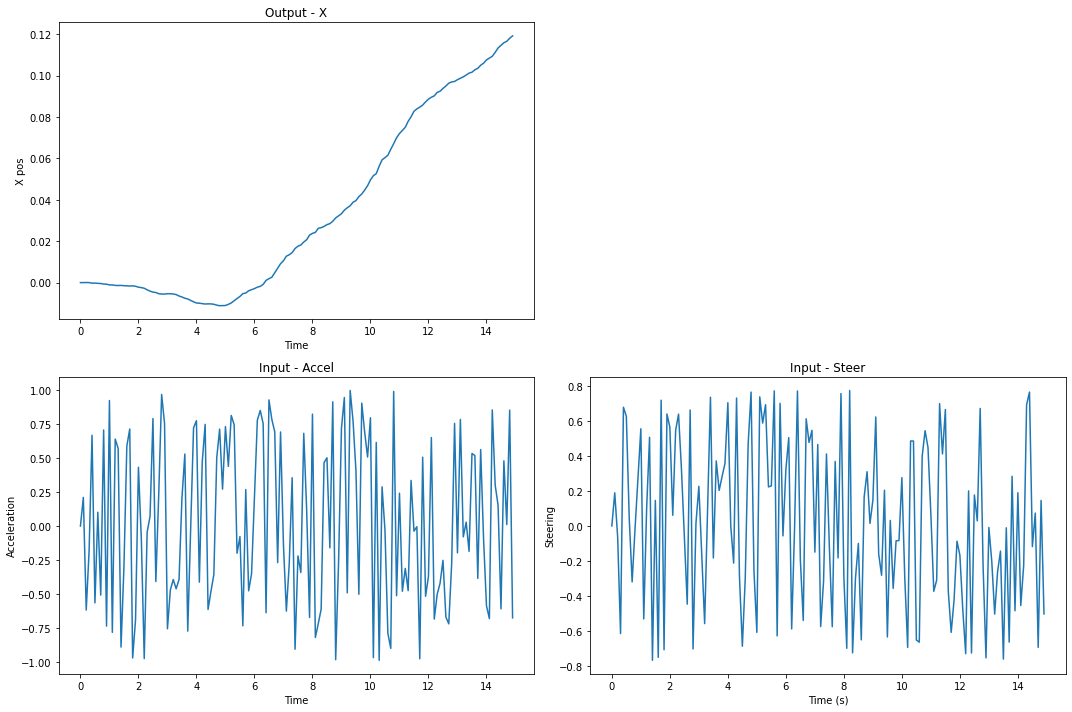

In [174]:
x_i = np.array([0,0,0,0])
x = x_i
y_i = C@x_i
y_T = [y_i]
u_T = [[0,0]]
T = 150

for i in range(0,T-1):
  a = np.random.uniform(low=MIN_ACCEL, high=MAX_ACCEL)
  delta = np.random.uniform(low=MIN_STEER, high=MAX_STEER)
  u = [a, delta]
  A, B, h = get_linear_model_matrix(x[-2],x[-1],u[-1])
  x = A@x + B@u + h
  y = C@x
  y_T.append(y)
  u_T.append(u)

plt.rcParams["figure.figsize"] = (15,10)

time = np.array(list(range(0,T)))*DT
plt.subplot(2,2,1)
plt.plot(time, y_T)
plt.xlabel('Time')
plt.ylabel("X pos")
plt.title("Output - X")

u_T = np.array(u_T)
plt.subplot(2,2,3)
plt.plot(time, u_T[:,0])
plt.xlabel('Time')
plt.ylabel("Acceleration")
plt.title("Input - Accel")

plt.subplot(2,2,4)
plt.plot(time, u_T[:,1])
plt.xlabel('Time (s)')
plt.ylabel("Steering")
plt.title("Input - Steer")
plt.tight_layout()

plt.show()

In [175]:
T_ini = 4
n = 4
N = 30
L = T_ini + N + n

H = hankel(u_T[0:L,:], u_T[L:,:])
print(f'H has rank {np.linalg.matrix_rank(H)} and shape {H.shape}')


H has rank 76 and shape (76, 224)


In [176]:
L = T_ini + N
U = hankel(u_T[0:L,:], u_T[L:,1])
Y = hankel(y_T[0:L], y_T[L:])

Up = U[0:(2*T_ini), :]
Uf = U[(2*T_ini):, :]
print(f'U = {U.shape}, Up = {Up.shape}, Uf = {Uf.shape}')

Yp = Y[0:T_ini, :]
Yf = Y[T_ini:, :]
print(f'Y = {Y.shape}, Yp = {Yp.shape}, Yf = {Yf.shape}')

u_ini = np.zeros(T_ini*2)
y_ini = np.zeros(T_ini)

A = np.vstack([Up, Yp, Uf, Yf])

U = (68, 116), Up = (8, 116), Uf = (60, 116)
Y = (34, 116), Yp = (4, 116), Yf = (30, 116)


## Solver

In [181]:
g = cp.Variable(T - T_ini - N)
u = cp.Variable(2*N)
y = cp.Variable(N)
b = np.hstack([u_ini, y_ini, u, y])

r = np.ones(N)
Q = np.eye(N)
R = np.eye(2*N)

cost = cp.quad_form(y - r, Q) + cp.quad_form(u,R)

constraints = [
    Up @ g == u_ini,
    Yp @ g == y_ini,
    Uf @ g == u,
    Yf @ g == y,
    # u[1,:] <= MAX_STEER,
    # u[0,:] <= MAX_ACCEL
]

prob = cp.Problem(cp.Minimize(cost), constraints)
prob.solve(solver=cp.OSQP, verbose=True)

                                     CVXPY                                     
                                     v1.2.3                                    
(CVXPY) Feb 25 02:36:24 PM: Your problem has 206 variables, 4 constraints, and 0 parameters.
(CVXPY) Feb 25 02:36:24 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Feb 25 02:36:24 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Feb 25 02:36:24 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Feb 25 02:36:24 PM: Compiling problem (target solver=OSQP).
(CVXPY) Feb 25 02:36:24 PM: Reduction chain: CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStuffin

6.985985241032763e-14

()